<h1>The Data</h1>
All of my match data was sourced from OpenDota, an open-source data platform that grabs its data directly from Steam. OpenDota provides a great API for developers to build their own applications with. The data I'll be working with comes from two GET requests to the API; one for my match data, and one for general hero data. I loaded this data into a MySQL database and exported it into two CSV files - one with my match data joined with hero data and one with the hero data on its own - which I'll work with using Python's Pandas module. The code and CSVs I used for all of this can be found on my Github.

<h1>Loading and Preparing the Data</h1>
<p>Before I can do any analysis, I'll have to load the data and clean things up a little bit.</p>

In [1]:
### Imports

# Data Analysis
import pandas as pd
pd.options.display.max_columns = 50
import datetime # Working with time data
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

<h1>DataFrame 1: Match Data</h1>
This first dataset contains information on every match of Dota 2 I've ever played, plus additional information about the hero I chose to play as.

In [2]:
### Load the data
data = pd.read_csv('dota_stats.csv')
headers = data.columns
headers # List of data variables

Index(['result', 'radiant_win', 'duration', 'start_time', 'game_mode',
       'localized_name', 'kills', 'deaths', 'assists', 'primary_attr',
       'attack_type', 'carry', 'jungler', 'pusher', 'nuker', 'disabler',
       'initiator', 'durable', 'support', 'legs'],
      dtype='object')

<h2>A list of the data variables recorded for each match. Here's what they mean:</h2>

<ul>
    <li><strong>result:</strong> Whether the team I was on won or not. 1 = Win, 0 = Loss.</li>
    <li><strong>radiant_win:</strong> Whether the team on the Radiant side of the map won. 1 = True, 0 = False.</li>
    <li><strong>duration:</strong> How long the match lasted, in seconds.</li>
    <li><strong>start_time:</strong> The exadct time the match started, measured in seconds since the Coordinated Universal Time stamp, January 1st, 1970</li>
    <li><strong>game_mode:</strong> The game mode I was playing in. An irrelevant variable that'll be deleted later, since I found OpenDota's API to be unclear on the label encoding used for each mode.</li>
    <li><strong>localized_name:</strong> The name of the hero I played. Will be changed to 'Hero' later for brevity.</li>
    <li><strong>kills:</strong> The number of enemy heroes I killed during the match.</li>
    <li><strong>deaths:</strong> The number of times I died during the match, either to enemy heroes or units, neutral creeps, or suicide.</li>
    <li><strong>assists:</strong> The number of times I assisted a teammate in getting a kill.</li>
    <li><strong>primary_attr:</strong> The primary attribute of my hero. Either agi (agility), int (intelligence), or str (strength).</li>
    <li><strong>attack_type:</strong> How my hero does basic attacks. Either melee or ranged.</li>
    <li><strong>carry:</strong> A hero that is the strongest in the lategame with more experience and items. 1 = Yes, 0 = No (same for all other roles).</li>
    <li><strong>jungler:</strong> A hero that can spend the early game fighting neutral creeps in the jungle to gain experience and gold.</li>
    <li><strong>pusher:</strong> A hero that can quickly push lanes and destroy enemy buildings.</li>
    <li><strong>nuker:</strong> A hero that can cast damage-dealing spells to quickly kill enemy heroes.</li>
    <li><strong>disabler:</strong> A hero that can cast spells to prevent enemy heroes from doing things (e.g. stunning a hero so it can't move or attack, removing its damage, silencing it so it can't cast spells).</li>
    <li><strong>initiator:</strong> A hero that is good at starting and controlling major teamfights.</li>
    <li><strong>durable:</strong> A hero that has a lot of health or armor, allowing it to withstand fights and take a lot of damage.</li>
    <li><strong>support:</strong> A hero that has a lot of spells useful for helping out the team, either by healing or strengthening allies. Often delegated to buy support items (i.e. wards, dust) for the team.</li>
    <li><strong>legs:</strong> The number of legs my hero has. (Irrelevant?)</li>
</ul>

First things first - how many games did I play?

In [3]:
total_games = len(data)
total_games

555

In [4]:
headers_list = list(headers)
headers_list[5] = 'hero' # change 'localized_named' to 'hero'
data.columns = headers_list

Here's what the head (first 5 rows) of the data looks like. The data is stored in a pandas DataFrame object.

In [5]:
data.head()

,result,radiant_win,duration,start_time,game_mode,hero,kills,deaths,assists,primary_attr,attack_type,carry,jungler,pusher,nuker,disabler,initiator,durable,support,legs
0,0,1,3212,1639033178,22,Snapfire,4,8,17,all,Ranged,0,0,0,1,1,0,0,1,2
1,1,1,2571,1640818822,22,Bristleback,5,4,19,str,Melee,1,0,0,1,0,1,1,0,2
2,0,1,2142,1641277499,22,Chaos Knight,1,7,9,str,Melee,1,0,1,0,1,1,1,0,2
3,0,1,2025,1641775547,22,Lich,3,8,8,int,Ranged,0,0,0,1,0,0,0,1,2
4,1,0,3794,1646713648,22,Timbersaw,8,9,30,all,Melee,0,0,0,1,0,0,1,0,2


It's not ready for analysis yet - there are a few useful things we can add and clean up.

In [6]:
data['duration'] = round(data['duration'] /60)

First, we convert the match duration from seconds to minutes. Next, we'll use Python's <strong>datetime</strong> module to take the <strong>start_time</strong> timestamp data and move it into new <strong>year, month, day,</strong> and <strong>hour</strong> variables in the DataFrame.

In [7]:
year = []
month = []
day = []
hour = []
minute = []
for ix in data['start_time'].index:
    ts = datetime.datetime.fromtimestamp((data['start_time'][ix]))
    year.append(ts.year)
    month.append(ts.month)
    day.append(ts.day)
    hour.append(ts.hour)
    minute.append(ts.minute)
data.insert(3, 'year', year)
data.insert(4, 'month', month)
data.insert(5, 'day', day)
data.insert(6, 'hour', hour)
data.insert(7,'minute', minute)
data.drop('start_time', axis=1, inplace=True)

Here's what the DataFrame looks like with our time variables properly formatted:

In [8]:
data.head()

,result,radiant_win,duration,year,month,day,hour,minute,game_mode,hero,kills,deaths,assists,primary_attr,attack_type,carry,jungler,pusher,nuker,disabler,initiator,durable,support,legs
0,0,1,54.0,2021,12,8,22,59,22,Snapfire,4,8,17,all,Ranged,0,0,0,1,1,0,0,1,2
1,1,1,43.0,2021,12,29,15,0,22,Bristleback,5,4,19,str,Melee,1,0,0,1,0,1,1,0,2
2,0,1,36.0,2022,1,3,22,24,22,Chaos Knight,1,7,9,str,Melee,1,0,1,0,1,1,1,0,2
3,0,1,34.0,2022,1,9,16,45,22,Lich,3,8,8,int,Ranged,0,0,0,1,0,0,0,1,2
4,1,0,63.0,2022,3,7,20,27,22,Timbersaw,8,9,30,all,Melee,0,0,0,1,0,0,1,0,2


Next, we're going to split the values in both <strong>primary_attr</strong> and <strong>attack_type</strong> into new dummy variables, to make things easier for manipulation later on. This adds the columns <strong>agi, int, str, all,  melee,</strong> and <strong>ranged</strong> to the DataFrame.

In [9]:
primary_attr = pd.get_dummies(data['primary_attr'])
attack_type = pd.get_dummies(data['attack_type'])
data = pd.concat([data, primary_attr, attack_type], axis=1)

Now we add two new variables into the DataFrame: Kill/Death Ratio (<strong>kdr</strong>) and Kill/Death/Assist Ratio (<strong>kda</strong>). These are aggregates of the <strong>kill, death,</strong> and <strong>assist</strong> variables which provide good descriptive values to the balance of the three scored in each match.

<strong>Kill/Death Ratio (KDR)</strong> = <i>kills/deaths</i>
<strong>Kill/Death/Assist Ratio (KDA)</strong> = <i>(kills+assists)/deaths</i>

In [10]:
kda = (data['kills'] + data['assists'])/data['deaths']
kdr = data['kills']/data['deaths']
data.insert(13, 'kda', kda)
data.insert(14, 'kdr', kdr)

There were some matches I played where I never died once. This will throw the KDR and KDA ratios off for these matches however, since there'll be a division by 0. To mitigate this, for matches where I didn't die, I'll adjust the ratios to divide by 1 instead.

In [11]:
data.kdr[data.deaths == 0] = data.kills[data.deaths == 0] / 1
data.kda[data.deaths == 0] = (data.kills[data.deaths == 0] + data.assists[data.deaths == 0]) / 1

<ipython-input-11-5c1037ea08c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.kdr[data.deaths == 0] = data.kills[data.deaths == 0] / 1
<ipython-input-11-5c1037ea08c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.kda[data.deaths == 0] = (data.kills[data.deaths == 0] + data.assists[data.deaths == 0]) / 1


Finally, let's drop <strong>game_mode</strong>, since it offers no valuable insight for this analysis. The vast majority of my games (atleast 95% if I had to guess) were played in All Pick Mode, where players can directly pick the hero they want to play for the match.
I'm also removing <strong>jungler</strong> as no heroes are classified as it now.

In [12]:
data.drop(['jungler'], axis=1, inplace=True)
data.drop(['game_mode'], axis=1, inplace=True)

With these adjustments made, we've now got a clean and easy DataFrame to work with.

In [13]:
data.head()

,result,radiant_win,duration,year,month,day,hour,minute,hero,kills,deaths,assists,kda,kdr,primary_attr,attack_type,carry,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
0,0,1,54.0,2021,12,8,22,59,Snapfire,4,8,17,2.625000,0.500000,all,Ranged,0,0,1,1,0,0,1,2,0,1,0,0,0,1
1,1,1,43.0,2021,12,29,15,0,Bristleback,5,4,19,6.000000,1.250000,str,Melee,1,0,1,0,1,1,0,2,0,0,0,1,1,0
2,0,1,36.0,2022,1,3,22,24,Chaos Knight,1,7,9,1.428571,0.142857,str,Melee,1,1,0,1,1,1,0,2,0,0,0,1,1,0
3,0,1,34.0,2022,1,9,16,45,Lich,3,8,8,1.375000,0.375000,int,Ranged,0,0,1,0,0,0,1,2,0,0,1,0,0,1
4,1,0,63.0,2022,3,7,20,27,Timbersaw,8,9,30,4.222222,0.888889,all,Melee,0,0,1,0,0,1,0,2,0,1,0,0,1,0


In [14]:
data.tail()

,result,radiant_win,duration,year,month,day,hour,minute,hero,kills,deaths,assists,kda,kdr,primary_attr,attack_type,carry,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
550,1,0,54.0,2023,4,24,19,6,Snapfire,14,9,20,3.777778,1.555556,all,Ranged,0,0,1,1,0,0,1,2,0,1,0,0,0,1
551,1,0,39.0,2023,4,25,9,39,Snapfire,9,4,26,8.750000,2.250000,all,Ranged,0,0,1,1,0,0,1,2,0,1,0,0,0,1
552,0,0,46.0,2023,4,25,10,30,Snapfire,6,6,12,3.000000,1.000000,all,Ranged,0,0,1,1,0,0,1,2,0,1,0,0,0,1
553,0,1,30.0,2023,4,25,18,52,Snapfire,4,7,5,1.285714,0.571429,all,Ranged,0,0,1,1,0,0,1,2,0,1,0,0,0,1
554,0,1,50.0,2023,4,25,22,29,Riki,13,10,13,2.600000,1.300000,agi,Melee,1,0,0,1,0,0,0,2,1,0,0,0,1,0


<h1>DataFrame 2: Hero Data</h1>
The second dataset I'm loading in only contains the variables for each hero in the game: their hero name, primary attribute, attack type, roles, and number of legs. I'll use this DataFrame to look at the distribution of these variables across the entire hero pool later on.

In [15]:
hero_data = pd.read_csv("dota_hero_stats.csv")

hero_headers = list(hero_data.columns)
hero_headers[0] = 'hero' # change 'localized_named' to 'hero'
hero_data.columns = hero_headers

hero_primary_attr = pd.get_dummies(hero_data['primary_attr'])
hero_attack_type = pd.get_dummies(hero_data['attack_type'])
hero_data = pd.concat([hero_data, hero_primary_attr, hero_attack_type], axis=1)

hero_data.tail()

,hero,localized_name,primary_attr,attack_type,carry,jungler,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
119,129,Mars,str,Melee,1,0,0,0,1,1,1,0,2,0,0,0,1,1,0
120,135,Dawnbreaker,str,Melee,1,0,0,0,0,0,1,0,2,0,0,0,1,1,0
121,136,Marci,all,Melee,1,0,0,0,1,1,0,1,2,0,1,0,0,1,0
122,137,Primal Beast,str,Melee,0,0,0,0,1,1,1,0,2,0,0,0,1,1,0
123,138,Muerta,int,Ranged,1,0,0,1,1,0,0,0,2,0,0,1,0,0,1


Done! Let's get down to business.

In [16]:
data.describe()

,result,radiant_win,duration,year,month,day,hour,minute,kills,deaths,assists,kda,kdr,carry,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,0.522523,0.542342,43.187387,2022.326126,6.259459,15.457658,18.765766,28.740541,7.041441,6.699099,15.893694,5.198680,1.795723,0.560360,0.196396,0.650450,0.832432,0.392793,0.372973,0.445045,2.111712,0.282883,0.284685,0.187387,0.245045,0.459459,0.540541
std,0.499943,0.498653,9.985776,0.476849,3.443363,8.557910,4.009814,16.878983,5.042428,3.398011,8.285816,5.597868,2.681323,0.496791,0.397630,0.477258,0.373819,0.488812,0.484031,0.497419,1.217408,0.450806,0.451671,0.390574,0.430502,0.498803,0.498803
min,0.000000,0.000000,10.000000,2021.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,36.000000,2022.000000,3.000000,8.000000,17.000000,15.000000,3.000000,4.000000,10.000000,2.080128,0.428571,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,42.000000,2022.000000,6.000000,16.000000,20.000000,28.000000,6.000000,7.000000,15.000000,3.363636,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,49.000000,2023.000000,9.000000,23.000000,22.000000,42.000000,10.000000,9.000000,20.000000,5.750000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,84.000000,2023.000000,12.000000,31.000000,23.000000,59.000000,33.000000,19.000000,60.000000,37.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1>Analysis</h1>

<h2>Win/Loss Ratio</h2>
First things first; the ultimate measure of whether you're a scrub or a pro... A legend or a mockery... The Win/Loss Ratio.

In [17]:
wins = len(data[data['result'] == 1])
wins_pct = round(wins/total_games, 3) * 100
losses = len(data[data['result'] == 0])
losses_pct = round(losses/total_games, 3) * 100

print(f'Wins: {wins} ({wins_pct}%)')
print(f'Losses: {losses} ({losses_pct}%)')

Wins: 290 (52.300000000000004%)
Losses: 265 (47.699999999999996%)


On average, I'm (slightly more often) a <strong>*WINNER!*</strong> In all seriousness, I'm not some DotA pro, so it makes sense to have such an average W/L. Sometimes you win, sometimes you don't. Approximately half of the time. <strong>For this reason, we're going to consider a W/L ratio of 0.5 the baseline</strong>; ratios below it are bad, but ratios above it are good. Throughout this analysis I'll examine how certain variables affect my chances of winning relative to this baseline.

<h1>Radiant/Dire Advantage</h1>
In Dota, you play on one of two teams: the Radiant or the Dire. There's no difference between being on either team except for the fact that the battlefield both teams play on is slightly asymmetrical. For a long time there was the conventional wisdom that the Dire team had a slight advantage as Roshan (a powerful monster on the map which drops an item that revives heroes) was on their side of the river that intersects the map. This has been disproven however, and the general consensus is that there is no substantive advantage that comes with being on a specific team. In theory, this should be reflected in my match results:

In [18]:
radiant_wins = data['radiant_win'].value_counts()

print('Radiant Win %:', round(radiant_wins[1]/len(data), 3))
print('Dire Win %:', round(radiant_wins[0]/len(data), 3))

Radiant Win %: 0.542
Dire Win %: 0.458


There appears to be an advantage to being on the Radiant side.

<h1>Numerical Distributions</h1>
While Win/Loss and Radiant/Dire Advantage are interesting to look at, whether you win or lose in DotA is a result of your team - the sum is greater than the individual parts, as they say. Focusing more on my personal performance, a good place to start is the distribution of some numerical variables in the dataset. A boxplot will show where the first quartile, median, third quartile, and outliers lie for a given variable. What I've decided to plot below are the most interesting ones to investigate: <strong>duration, kills, deaths, assists, kdr, kda.</strong>

Text(0.5, 1.0, 'KDA')

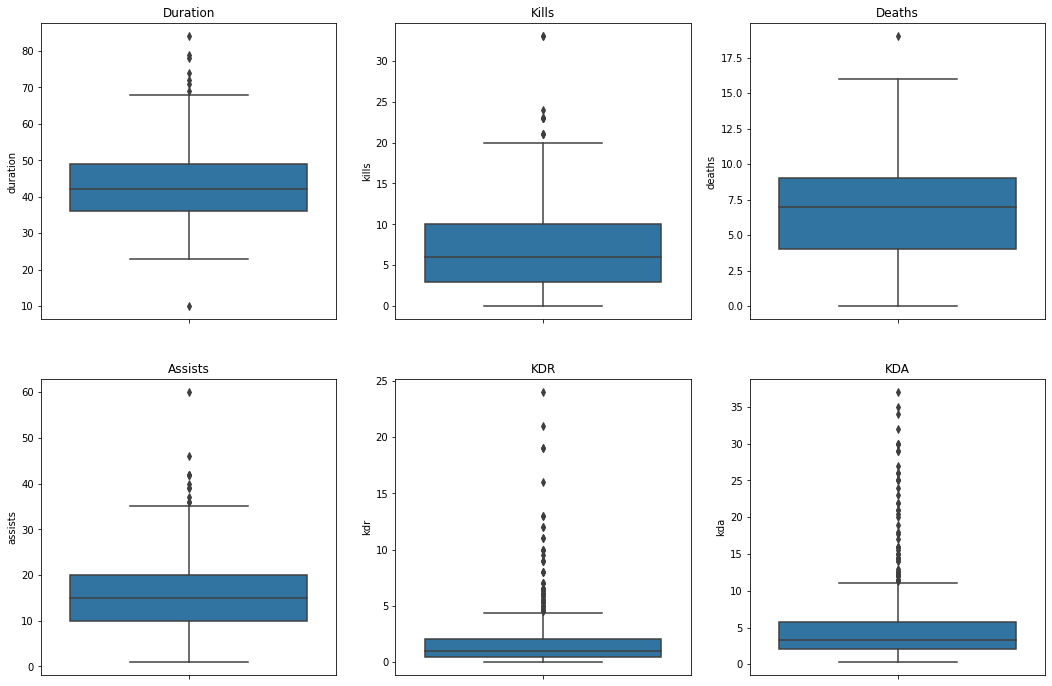

In [19]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(y=data['duration'])
plt.title('Duration')

plt.subplot(2,3,2)
sns.boxplot(y=data['kills'])
plt.title('Kills')

plt.subplot(2,3,3)
sns.boxplot(y=data['deaths'])
plt.title('Deaths')

plt.subplot(2,3,4)
sns.boxplot(y=data['assists'])
plt.title('Assists')

plt.subplot(2,3,5)
sns.boxplot(y=data['kdr'])
plt.title('KDR')

plt.subplot(2,3,6)
sns.boxplot(y=data['kda'])
plt.title('KDA')

This same data can be displayed in a table through pandas' <strong>describe</strong> function:

In [20]:
data.describe()

,result,radiant_win,duration,year,month,day,hour,minute,kills,deaths,assists,kda,kdr,carry,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,0.522523,0.542342,43.187387,2022.326126,6.259459,15.457658,18.765766,28.740541,7.041441,6.699099,15.893694,5.198680,1.795723,0.560360,0.196396,0.650450,0.832432,0.392793,0.372973,0.445045,2.111712,0.282883,0.284685,0.187387,0.245045,0.459459,0.540541
std,0.499943,0.498653,9.985776,0.476849,3.443363,8.557910,4.009814,16.878983,5.042428,3.398011,8.285816,5.597868,2.681323,0.496791,0.397630,0.477258,0.373819,0.488812,0.484031,0.497419,1.217408,0.450806,0.451671,0.390574,0.430502,0.498803,0.498803
min,0.000000,0.000000,10.000000,2021.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,36.000000,2022.000000,3.000000,8.000000,17.000000,15.000000,3.000000,4.000000,10.000000,2.080128,0.428571,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,42.000000,2022.000000,6.000000,16.000000,20.000000,28.000000,6.000000,7.000000,15.000000,3.363636,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,49.000000,2023.000000,9.000000,23.000000,22.000000,42.000000,10.000000,9.000000,20.000000,5.750000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,84.000000,2023.000000,12.000000,31.000000,23.000000,59.000000,33.000000,19.000000,60.000000,37.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Duration:
<ul>
<li>Most games last between 36 and 49 minutes, with a median of 42 minutes. So if the game is trash, you're trapped for the better half of an hour.</li>
<li>Shortest game was 10 minutes (someone disconnects after firstblood and the rest of their team leaves), longest game was 1 hour 24 minutes. Did I win that game?</li>
</ul>

In [21]:
data.loc[data['duration'] ==84]['result']

102    1
Name: result, dtype: int64

Heck yeah; that's a hard fought win.

<h1>Kills/Deaths/Assists/KDR/KDA</h1>
<ul>
<li>Average 7.04 kills per match, 6.69 deaths, 15.89 assists. The median, not as affected by outliers, gives what I consider to be a more typical representation: 6 kills, 7 deaths, 15 assists. The standard deviations for kills and assists are wide compared to the medians, while the standard deviation for deaths is a bit smaller. This means that there is a greater amount of variance in the kills I get per match, but I generally average pretty close to 7 deaths.</li>

<li>Max kills: 33. Max deaths: 19.</li>

<li>KDR and KDA naturally follow the ratios given for kills, deaths, and assists. Mean KDA: 5.19, Mean KDR: 1.79. Median KDA: 3.36, Median KDR: 1. The median KDR comes from both median kills and deaths being close. The thing about DotA is, if you're losing, you're often getting wiped - getting wrecked by the other team and dying a lot. On the flip side, when you're winning, your KDA and KDR ratios will be pretty high (although not so much for KDR if you're a support). To demonstrate this, let's partition the data into wins and losses and examine the median KDRs and KDAs.</li>
</ul>

In [22]:
wins = data[data['result'] == 1]
losses = data[data['result'] == 0]

attrs = ['kdr', 'kda']
for a in attrs:
    print('Win', a, ':', wins[a].median())
    print('Loss', a, ':', losses[a].median())

Win kdr : 1.6666666666666667
Loss kdr : 0.5714285714285714
Win kda : 5.5
Loss kda : 2.1


The majority of kills and deaths in DotA will largely occur as a result of teamfights in the mid to late game; where either one team (or both) have reached enough strength to make concentrated pushes towards the enemy's ancient. The outcome of these teamfights can have a pretty major impact on the momentum of the match, which will translate into the number of kills and deaths each player has. If you're winning the game, you're winning teamfights and slaying the other team. When you're losing... you're getting slayed. This is reflected pretty well in the ratios.</br>
Let's examine the matches where I <i>definitely</i> slayed: the upper kill outlier matches (20+ kills):

In [23]:
data[data['kills'] > 20]

,result,radiant_win,duration,year,month,day,hour,minute,hero,kills,deaths,assists,kda,kdr,primary_attr,attack_type,carry,pusher,nuker,disabler,initiator,durable,support,legs,agi,all,int,str,Melee,Ranged
39,1,1,45.0,2022,4,21,19,19,Legion Commander,23,6,22,7.500000,3.833333,str,Melee,1,0,1,1,1,1,0,2,0,0,0,1,1,0
50,1,0,66.0,2022,5,21,17,47,Drow Ranger,23,11,18,3.727273,2.090909,agi,Ranged,1,1,0,1,0,0,0,2,1,0,0,0,0,1
82,1,0,50.0,2022,6,11,12,34,Chaos Knight,21,4,19,10.000000,5.250000,str,Melee,1,1,0,1,1,1,0,2,0,0,0,1,1,0
278,0,0,67.0,2022,10,27,23,59,Naga Siren,23,6,23,7.666667,3.833333,agi,Melee,1,1,0,1,1,0,1,0,1,0,0,0,1,0
325,1,0,44.0,2022,11,21,15,17,Chaos Knight,21,6,9,5.000000,3.500000,str,Melee,1,1,0,1,1,1,0,2,0,0,0,1,1,0
342,1,0,52.0,2022,11,27,16,46,Huskar,23,8,19,5.250000,2.875000,str,Ranged,1,0,0,0,1,1,0,2,0,0,0,1,0,1
358,1,0,45.0,2022,12,2,18,38,Sniper,23,4,19,10.500000,5.750000,agi,Ranged,1,0,1,0,0,0,0,2,1,0,0,0,0,1
366,1,0,68.0,2022,12,7,20,44,Sniper,33,10,20,5.300000,3.300000,agi,Ranged,1,0,1,0,0,0,0,2,1,0,0,0,0,1
370,1,1,43.0,2022,12,30,17,33,Huskar,21,1,11,32.000000,21.000000,str,Ranged,1,0,0,0,1,1,0,2,0,0,0,1,0,1
407,1,1,42.0,2023,2,2,18,49,Slark,24,0,11,35.000000,24.000000,agi,Melee,1,0,1,1,0,0,0,2,1,0,0,0,1,0


A couple things to notice here. First, not all wins - your team has to be from a whole other dimension of suck to lose when you're doing this well(like in that Naga Siren game). Second, all these heroes are carries.

<h1>Variable Correlation</h1>
A way to get a great overview of the variables in the dataset, and see which ones are particularly important, is to make a correlation matrix. This will show us which variables are positively and negatively correlated. If variable A is positively correlated with variable B, when A goes up, so does B. A negatively correlation would be when A goes down, B goes up.

In [24]:
match_corr = data.corr()
import seaborn as sns

Text(0.5, 1.0, 'Correlation Matrix of Match Variables')

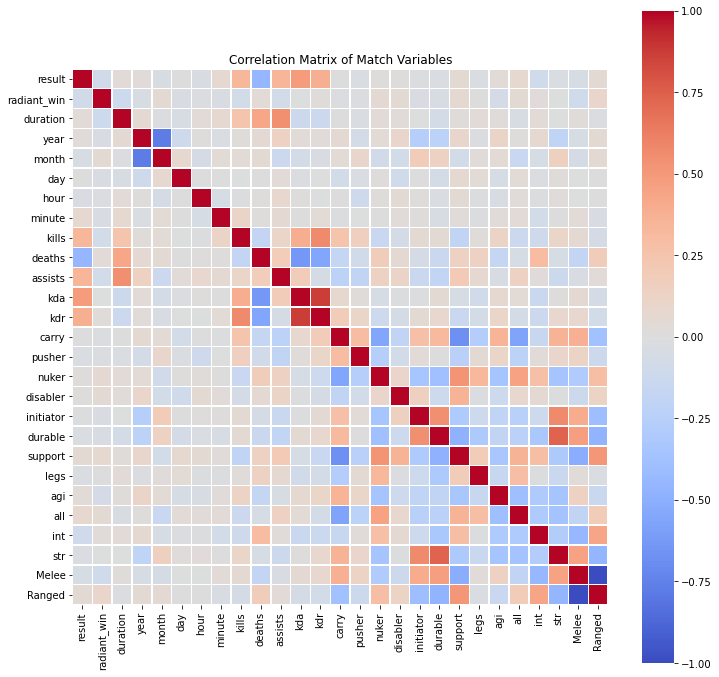

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(match_corr, vmax=1, square=True, linewidth=.5, cmap="coolwarm")
plt.title('Correlation Matrix of Match Variables')

The hotter a square looks, the more positively correlated its row/column variables are. The colder, the more negatively correlated.
<ul>
    <li>Some variables have very obvious correlations. For example, the correlation between Melee and Ranged attack types is -1; you can only be one or the other. KDR and KDA have a very strong positve correlation, because they're both derived from largely the same variables (kills and deaths).</li>
    <li>The duration of the game has positive correlations with kills, deaths, and assists. This intuitively makes sense; longer games mean more time spent fighting, killing, and dying. What's most interesting is that duration is more strongly correlated with deaths than kills. This would suggest that in longer games, I'm more likely to die than kill.</li>
    <li>That being said, there's no substantive correlation between duration and match result. Result shows moderate positve correlations with kills, deaths, KDR, and KDA. The strongest correlation is with KDA, suggesting that it's more important to have a higher KDA than it is to have a higher KDR if you want to win. The only difference between the two metrics is assists, showing that the more you can help your teammates get kills, the more likely your team is to win. Playing with the team is more effective than being a lone wolf - shocking!</li>
    <li>Hero roles, attributes, and attack types are correlated (more on all these things soon to come). Strength heroes are postively correlated with being melee and durable. Intelligence heroes are positively correlated with being supports and ranged (and are negatively correlated with being durable). Agility heroes have a moderate positve correlation with being carries, but don't have any correlations with either attack type.</li>
</ul>

<h1>Hero Stats</h1>
In Dota 2, every player controls a unique hero character. How well you can play your chosen hero, and how well it fits into your team's lineup, are crucial factors in winning a match. In this section I'll examine which heroes I played the most, and had the best W/L, KDR, and KDA ratios with. At the time of writing this, there are currently 124 heroes to pick from in Dota 2.

In [26]:
total_hero_pool = len(hero_data)
ive_played = len(data['hero'].unique())
ive_played_pct = round(ive_played/total_hero_pool, 2) * 100
print(f"I've played {ive_played} out of {total_hero_pool} total heroes atleast once, or {ive_played_pct}% of the total roster.")

I've played 81 out of 124 total heroes atleast once, or 65.0% of the total roster.


Although I've played 65% of all total heroes in the game, I haven't played them all in equal amounts. Because of this, it makes the most sense to pay attention to the ratios with heroes I've played a significant amount of times. To illustrate this point, let's look at the top 10 heroes I have the highest W/L ratios with:

Text(0.5, 0, 'Win Loss Ratio')

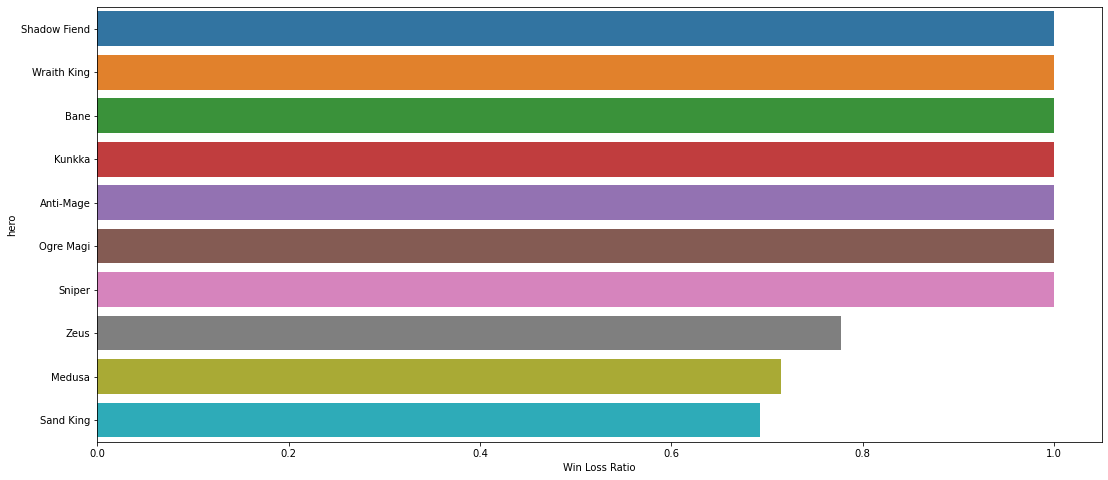

In [27]:
# Top 5 W/L ratios
plt.figure(figsize=(18,8))
hero = data.groupby('hero')
hero_winloss = hero['result'].mean().sort_values(ascending=False)
top_winloss = hero_winloss[:10]
sns.barplot(x=top_winloss, y=top_winloss.index)
plt.xlabel('Win Loss Ratio')

A perfect W/L ratio with 7 heroes(!), and over 70% ratio with the other three. But how often have I played each one?

In [28]:
for hero in top_winloss.index:
    times_played = len(data[data['hero'] == hero])
    times_played_pct = round(times_played / total_games, 3) * 100
    print(f"I've played {hero} {times_played} times, or {times_played_pct}% of my total games.")

I've played Shadow Fiend 1 times, or 0.2% of my total games.
I've played Wraith King 1 times, or 0.2% of my total games.
I've played Bane 1 times, or 0.2% of my total games.
I've played Kunkka 6 times, or 1.0999999999999999% of my total games.
I've played Anti-Mage 1 times, or 0.2% of my total games.
I've played Ogre Magi 1 times, or 0.2% of my total games.
I've played Sniper 3 times, or 0.5% of my total games.
I've played Zeus 9 times, or 1.6% of my total games.
I've played Medusa 7 times, or 1.3% of my total games.
I've played Sand King 13 times, or 2.3% of my total games.


Clearly, I'll have to sort by the number of times I've played each hero to get meaningful conclusions. For the purposes of this analysis, lets focus on the 30 heroes I've played the most.

In [29]:
hero_mostplayed30 = data['hero'].value_counts()[:30]
mostplayed30_winloss = hero_winloss[hero_mostplayed30.index]

In [30]:
total_hero_pct = 0
for num_games in hero_mostplayed30:
    pct = (num_games/total_games) * 100
    total_hero_pct += pct
print(f'The top 30 heroes account for {round(total_hero_pct, 2)}% of my total games.')

The top 30 heroes account for 77.12% of my total games.


These 30 heroes cover a good majority of my total games, so I'm comfortable leaving out the remaining 94. Let's start by looking at the top 30 heroes and their W/L ratios:

Text(0.5, 0, 'W/L Ratio')

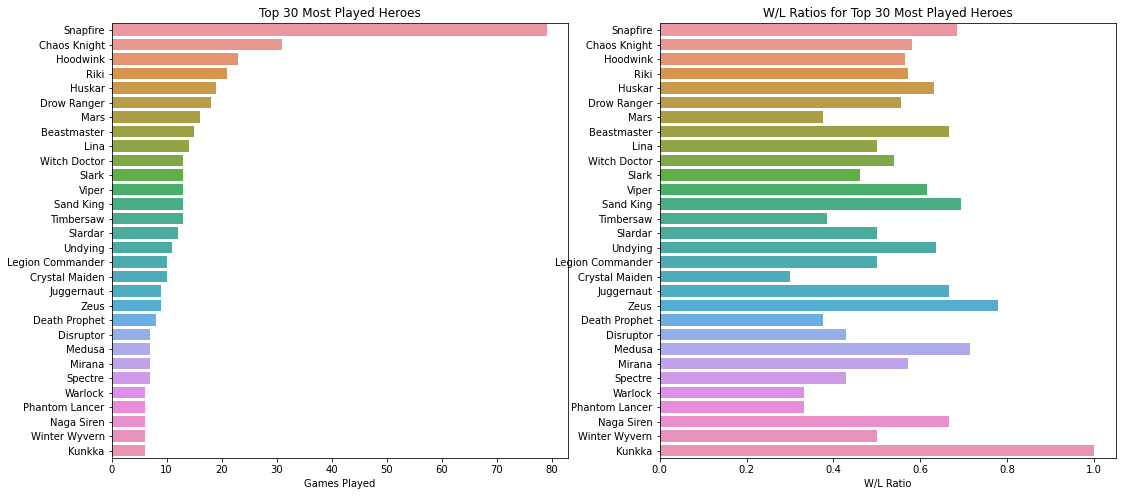

In [31]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
sns.barplot(x=hero_mostplayed30, y=hero_mostplayed30.index)
plt.title('Top 30 Most Played Heroes')
plt.xlabel('Games Played')

plt.subplot(1, 2, 2)
sns.barplot(x=mostplayed30_winloss, y=hero_mostplayed30.index)
plt.title('W/L Ratios for Top 30 Most Played Heroes')
plt.xlabel('W/L Ratio')

My top 6 played heroes are Snapfire, Chaos Knight, Hoodwink, Riki, Huskar and Drow Ranger. I've played each of these heroes over 20 times but obviously Snapfire (75+ games) is my most played and favorite hero.

In [32]:
print('Top 6 W/L Ratios')
print('----------------')
for hero in mostplayed30_winloss.index[:6]:
    print(hero, round(mostplayed30_winloss[hero],3))

Top 6 W/L Ratios
----------------
Snapfire 0.684
Chaos Knight 0.581
Hoodwink 0.565
Riki 0.571
Huskar 0.632
Drow Ranger 0.556


<ul>
    <li>This group of heroes do not share many roles (carries, supports, and a mid).</li>
    <li>Despite being played over 75 games, Snapfire has my highest W/L ratios at 0.685; I'm more likely to win games playing as this hero. Huskar is a close second having a W/L ratio of 0.632.</li>
    <li>Of my 30 most played heroes, Kunkka blows everyone else's W/L ratios out of the water, scoring a whopping 1.0. This is roughly 30% higher than the highest ratio in my top 6 heroes! However, given how much less I've played Kunkka compared to any of these heroes, it's unlikely that I'm really much more likely to win with Kunkka. I would imagine that playing more games would bring his W/L closer to those in the top 6.</li>
</ul>

Next, let's take a look at the KDR and KDA ratios of the top 30. For this portion of the Hero Analysis, I'm going to focus on the median values for these variables. In the numerical distributions section of the analysis, the boxplots showed a lot of upper-end outliers for kills and assists. I'm interested in the typical KDA and KDR performances for my top 30 heroes across the many games I've played, so using the median instead of the mean will give me numbers that are more resistant to those outlier matches.

In [33]:
mostplayed30_kdr = data.groupby('hero')['kdr'].median()[hero_mostplayed30.index]
mostplayed30_kda = data.groupby('hero')['kda'].median()[hero_mostplayed30.index]

Text(0.5, 0, 'KDA')

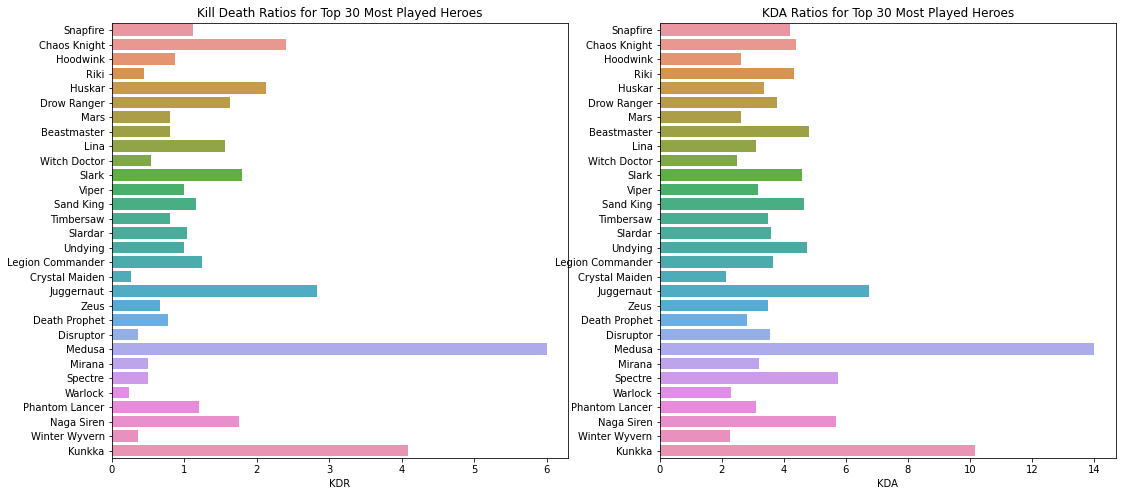

In [34]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
sns.barplot(x=mostplayed30_kdr, y=hero_mostplayed30.index)
plt.title('Kill Death Ratios for Top 30 Most Played Heroes')
plt.xlabel('KDR')

plt.subplot(1, 2, 2)
sns.barplot(x=mostplayed30_kda, y=hero_mostplayed30.index)
plt.title('KDA Ratios for Top 30 Most Played Heroes')
plt.xlabel('KDA')

My games with Medusa and Kunkka really skew the data here. I'd consider anything over 1:1 KDR or 3:1 KDA quite acceptable, especially as I mostly play support roles.

In [70]:
print('Medusa KDA:', mostplayed30_kda['Medusa'])
print('Kunkka KDA:', mostplayed30_kda['Kunkka'])

Medusa KDA: 14.0
Kunkka KDA: 10.166666666666668


Large differences between heroes' KDRs and KDAs can provide evidence about their general playstyles. For example, Beastmaster uses a lot of auras and minions to help make his whole team stronger but doesn't necessarily do a lot of damage himself for the final blows - leaving him with a higher KDA than KDR. Again, I cannot really explain the Medusa numbers as she is mostly a team fight hero and generally  I must have had some really good games.

Let's not get too hung up on the positives - which heroes in the top 30 do I die the most as? In DotA, the term used for excessively dying is "feeding", as with each death you help the enemy team grow stronger with gold and experience points. You don't want to be a feeder.

Text(0.5, 0, 'Avg. Number of Deaths per Match')

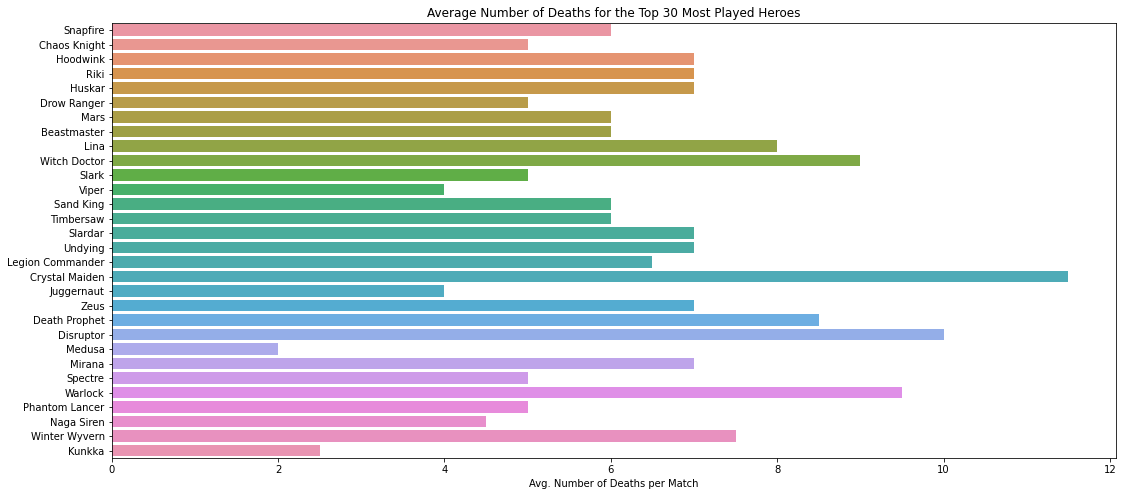

In [36]:
mostplayed30_deaths = data.groupby('hero')['deaths'].median()[hero_mostplayed30.index]

plt.figure(figsize=(18,8))
sns.barplot(x=mostplayed30_deaths, y=hero_mostplayed30.index)
plt.title('Average Number of Deaths for the Top 30 Most Played Heroes')
plt.xlabel('Avg. Number of Deaths per Match')

The ceiling (max value) for median deaths is around 12 per match, while the floor (min value) is 2. MOST of my heros fall at or below 7 deaths a match. Unsuprisingly, Medusa and Kunkka are the ones with the least amount of deaths.

Two of my most-played heroes with medians of 10-12 deaths are Crystal Maiden and Disruptor. Both of these intelligence heroes are typically played as supports, which can help explain the high death counts. Supports (should) prioritize helping the team grow stronger rather than growing stronger themselves, and as a result tend to be underleveled and underpowered as the game progresses. This makes them easy targets for enemy carries, where in teamfights they generally aim to pick off the easy kills before ganging up on tougher heroes to bring down.

The correlation matrix earlier showed a moderate negative correlation between deaths and result. This correlation can be evidenced by looking at the W/L ratios of my highest feeding heroes:

In [75]:
dead_guys = ['Lina', 'Witch Doctor', 'Death Prophet', 'Disruptor', 'Warlock', 'Riki', 'Hoodwink', 'Mirana']
good_or_bad_wl = ['<---- Good!' if mostplayed30_winloss[hero] > 0.5 else '<---- Bad!' for hero in dead_guys]
for ix, hero in enumerate(dead_guys):
    if len(hero) < 7:
        print(hero, '\t\tMed. # Deaths:', round(mostplayed30_deaths[hero],3),
              '\tW/L Ratio:', round(mostplayed30_winloss[hero],3), '\t', good_or_bad_wl[ix])
    elif len(hero) > 16:
         print(hero, '\tMed. # Deaths:', round(mostplayed30_deaths[hero],3),
               '\tW/L Ratio:', round(mostplayed30_winloss[hero],3), '\t', good_or_bad_wl[ix])
    else:
        print(hero, '\tMed. # Deaths:', round(mostplayed30_deaths[hero],3),
              '\tW/L Ratio:', round(mostplayed30_winloss[hero],3), '\t', good_or_bad_wl[ix])

Lina 		Med. # Deaths: 8.0 	W/L Ratio: 0.5 	 <---- Bad!
Witch Doctor 	Med. # Deaths: 9.0 	W/L Ratio: 0.538 	 <---- Good!
Death Prophet 	Med. # Deaths: 8.5 	W/L Ratio: 0.375 	 <---- Bad!
Disruptor 	Med. # Deaths: 10.0 	W/L Ratio: 0.429 	 <---- Bad!
Warlock 	Med. # Deaths: 9.5 	W/L Ratio: 0.333 	 <---- Bad!
Riki 		Med. # Deaths: 7.0 	W/L Ratio: 0.571 	 <---- Good!
Hoodwink 	Med. # Deaths: 7.0 	W/L Ratio: 0.565 	 <---- Good!
Mirana 		Med. # Deaths: 7.0 	W/L Ratio: 0.571 	 <---- Good!


Of the heros I chose I'm at about 50% Good and 50% Bad. 

Warlock appears to be my weakest hero of the group with an abysmal 0.333 W/L Ratio and median 9.5 Deaths per game. I guess I need to either work on my play with him or just stop playing him altogether.

Another interesting hero is Witch Doctor - with a median 9 Deaths per game but a positive W/L Ratio of 0.538 - sometimes you just feed.

In [38]:
import scipy.stats as stats

Riki's average assists: 29.761904761904763 Standard Deviation: 8.170240783913298
Death Prophet's average assists: 17.0 Standard Deviation: 8.689073598491383
Average assists across hero pool: 14.357594145891943 Standard Deviation: 6.283205744720406


Text(0.5, 1.0, "Riki and Death Prophet's Assists")

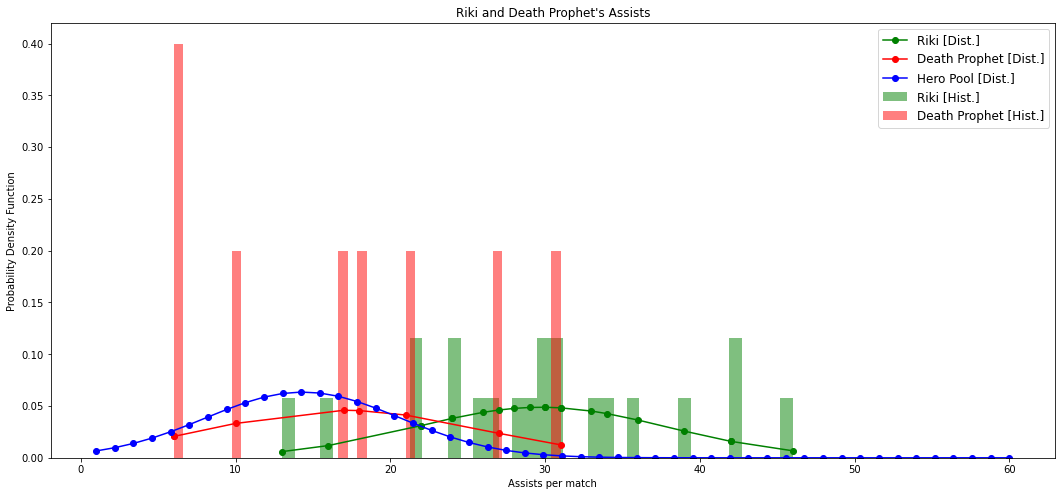

In [39]:
riki_sorted = sorted(data[data['hero'] == 'Riki']['assists'])
riki_mean = np.mean(riki_sorted)
riki_std = np.std(riki_sorted)

dp_sorted = sorted(data[data['hero'] == 'Death Prophet']['assists'])
dp_mean = np.mean(dp_sorted)
dp_std = np.std(dp_sorted)

pool_mean = data.groupby('hero')['assists'].mean().mean()
pool_std = data.groupby('hero')['assists'].std().mean()

min_assists = data['assists'].min()
max_assists = data['assists'].max()
assist_space = np.linspace(min_assists, max_assists)

print("Riki's average assists:", riki_mean, 'Standard Deviation:', riki_std) 
print("Death Prophet's average assists:", dp_mean, 'Standard Deviation:', dp_std)
print("Average assists across hero pool:", pool_mean, 'Standard Deviation:', pool_std)

plt.figure(figsize=(18,8))
plt.plot(riki_sorted, stats.norm.pdf(riki_sorted, riki_mean, riki_std), 'go-', label='Riki [Dist.]')
plt.hist(riki_sorted, bins=40, alpha=0.5, color='g', density=True, label='Riki [Hist.]')
plt.plot(dp_sorted, stats.norm.pdf(dp_sorted, dp_mean, dp_std), 'ro-', label='Death Prophet [Dist.]')
plt.hist(dp_sorted, bins=40, alpha=0.5, color='r', density=True, label='Death Prophet [Hist.]')
plt.plot(assist_space, stats.norm.pdf(assist_space, pool_mean, pool_std), 'bo-', label='Hero Pool [Dist.]')

plt.ylabel('Probability Density Function')
plt.xlabel('Assists per match')
plt.legend(fontsize='large')
plt.title("Riki and Death Prophet's Assists")

In the above histograms of Riki and Death Prophet's assists per match, we can see that Death Prophet's skews more than Riki's towards the lower end of the sample space. By fitting Riki, Death Prophet, and the entire hero pool's average assists to normal distributions, we get a decent approximation of how assists for the heroes are distributed. Death Prophets' distribution curve is closely in line with the rest of the hero pool, while Riki's is shifted more to the right. Centered around an average of ~30 assists per game, this shows that there's a greater chance of Riki having a high amount of assists per match (see the margin between Riki's distribution curve and the others around 15 assists).

In conclusion, if you're going to feed - atleast try to be useful to your team before you die!

<h1>Primary Attribute</h1>
Heroes come in four flavours: Agility, Intelligence, Strength and Universal(referred to as "all"). Everytime heroes level up, they are rewarded with a set number of attribute points.
<ul>
    <li>Agility points increase a hero's attack speed and armor</li>
    <li>Strength points increase a hero's overall health points and health regeneration rate</li>
    <li>Intelligence points increase a hero's overall mana points and mana regeneration rate</li>
    <li>Universal is a combination of the three previous and simply means a hero is not specifically any of the three alone</li>
<ul>

For heroes of a particular attribute, points in that attribute (either gained through leveling up or items) also increase the amount of damage they do each attack. Generally speaking, Agility heroes are carries, as their role is to deal massive amounts of damage through attacks. Strength heroes are the tanky durable heroes, often playing the role of initiator in fights - soak up as much damage as possible and force enemies to focus on you while your team does its thing. Intelligence heroes are typically supports, with nuking (i.e. burst damage) or disabling abilities. They want to fire off as many of their spells as possible and control the fight. This is the template most heroes follow, but there are plenty of exceptions and offshoots as well (e.g. Intelligence-based carry heroes).

Let's look at which primary attributes I played the most, as well as their W/L, KDR, and KDA ratios.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'KDA')

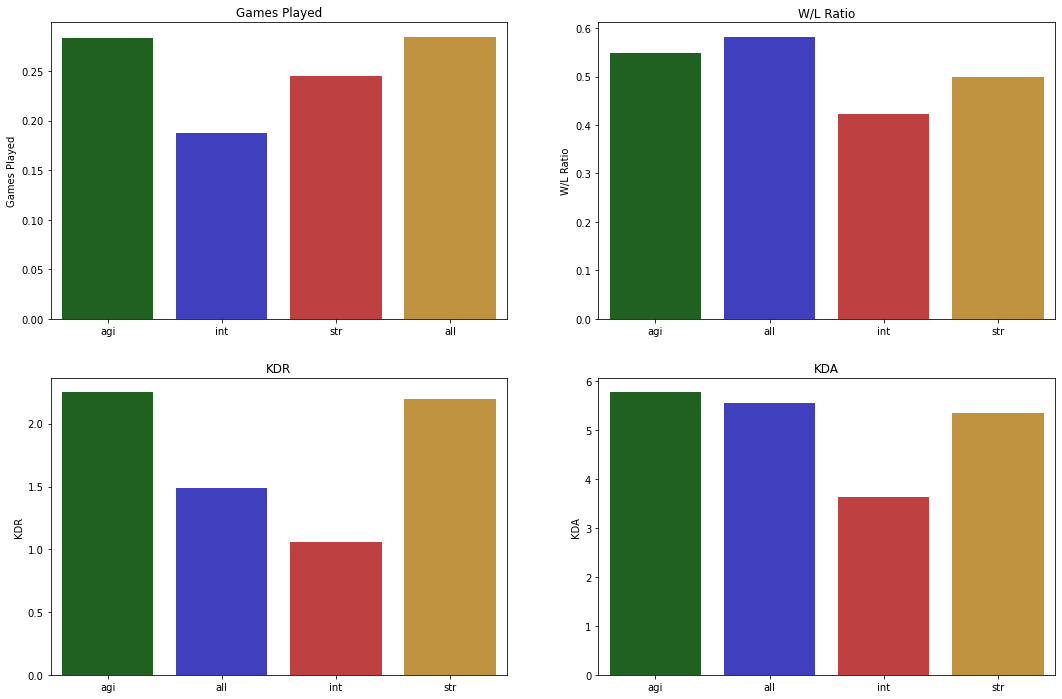

In [40]:
primary_attr = data['primary_attr'].value_counts().reindex(['agi', 'int', 'str', 'all'])
attr_palette = ['green', 'blue', 'red', 'orange'] # agi, int, str, all colours

plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.barplot(x=primary_attr.index, y=primary_attr/total_games, palette=attr_palette, saturation=0.5)
plt.ylabel('Games Played')
plt.title('Games Played')

plt.subplot(2, 2, 2)
primary_attr_wl = data.groupby('primary_attr')['result'].mean()
sns.barplot(primary_attr_wl.index, primary_attr_wl, palette=attr_palette, saturation=0.5)
plt.ylabel('W/L Ratio')
plt.xlabel('')
plt.title('W/L Ratio')

plt.subplot(2, 2, 3)
primary_attr_kdr = data.groupby('primary_attr')['kdr'].mean()
sns.barplot(primary_attr_kdr.index, primary_attr_kdr, palette=attr_palette, saturation=0.5)
plt.ylabel('KDR')
plt.xlabel('')
plt.title('KDR')

plt.subplot(2, 2, 4)
primary_attr_kda = data.groupby('primary_attr')['kda'].mean()
sns.barplot(primary_attr_kda.index, primary_attr_kda, palette=attr_palette, saturation=0.5)
plt.ylabel('KDA')
plt.xlabel('')
plt.title('KDA')

In [41]:
print(primary_attr_wl)
print(primary_attr_kdr)
print(primary_attr_kda)
# more closely examine

primary_attr
agi    0.547771
all    0.582278
int    0.423077
str    0.500000
Name: result, dtype: float64
primary_attr
agi    2.249774
all    1.486962
int    1.056054
str    2.195896
Name: kdr, dtype: float64
primary_attr
agi    5.766348
all    5.547476
int    3.628663
str    5.338740
Name: kda, dtype: float64


<ul>
    <li>Majority of my games were as either Agility or Universal heroes, with strength and intelligence following up with 24% and 19% respectively. The difference between intelligence and the other attributes shows a pretty clear bias against it (and perhaps supporting?).</li>
    <li>W/L ratios between attributes favors Universal at 0.58. Intelligence takes a dip at 0.42.</li>
    <li>Agility appears to be the winner for KDR, with an average ratio around 2.24 This can be explained by the generalization that most agility heroes are carries which get more kills. Conversely, the average for support-focused intelligence heroes is just above neutral.</li>
    <li>When taking assists into account with KDA, things even up considerably between the Agility, Strength and Universal attributes. Intelligence is still a clear last, but the distance between it, and the others is much less than KDR.</li>
    <li>While it's easier to see that intelligence heroes perform less well in all categories, the disclaimer here is that I've also played them considerably less. The difference in W/L, KDR, and KDA is still enough to suggest that conclusion, but I would imagine that intelligence's ratios would improve given more attention and practice.</li>
</ul>
Before we move on, let's see what the overall distribution of primary attributes is in the total hero pool:

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Primary Attributes across Total Hero Pool')

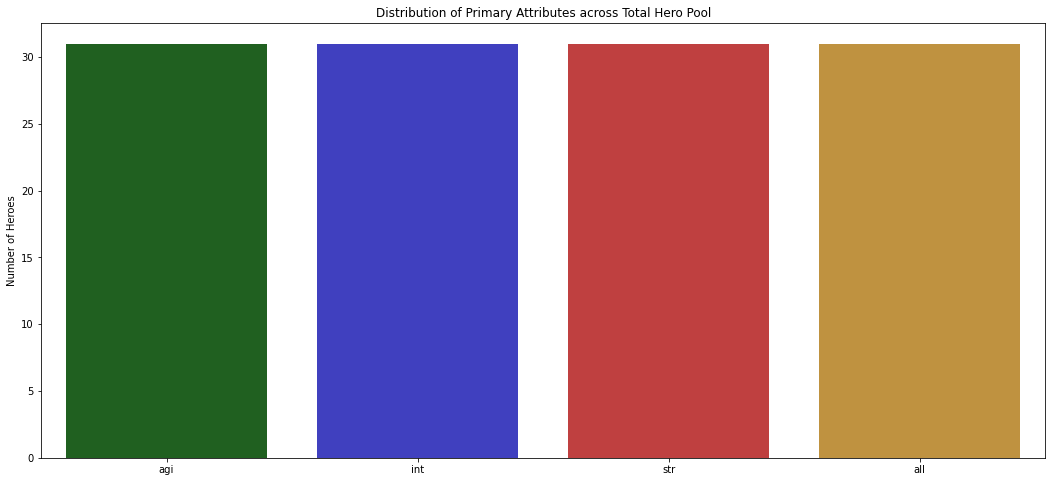

In [42]:
pool_primary_attr = hero_data['primary_attr'].value_counts().reindex(['agi', 'int', 'str', 'all'])
plt.figure(figsize=(18,8))
sns.barplot(pool_primary_attr.index, pool_primary_attr, palette=attr_palette, saturation=0.5)
plt.ylabel('Number of Heroes')
plt.xlabel('')
plt.title('Distribution of Primary Attributes across Total Hero Pool')

An even 31 heroes per attribute type.

In [43]:
## First, a nifty function to annotate barplots
def annotate(horizontal=False):
    ax = plt.gca()    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height() + 5, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

<h1>Attack Type</h1>
The two attack types, melee and ranged, are how heroes regularly attack enemy units. One slashes with claws, another throws fireballs, etc... There's even a hero that smacks people with tree branches, which is pretty fun.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

Text(0.5, 1.0, 'KDA')

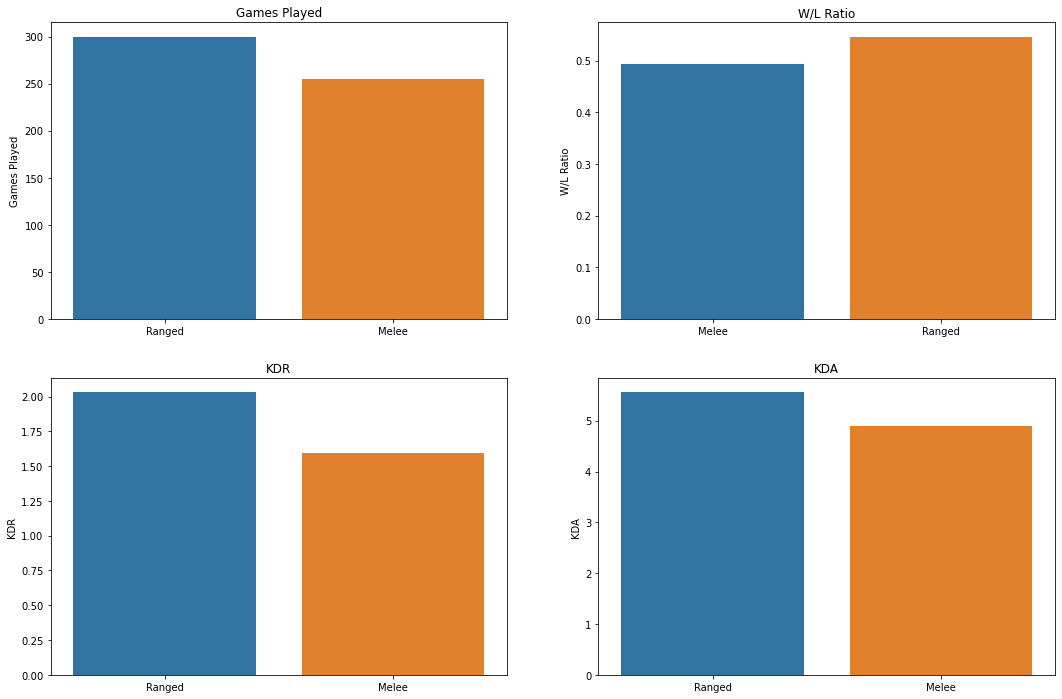

In [44]:
attack_type_total = data['attack_type'].value_counts()

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.barplot(attack_type_total.index, attack_type_total)
plt.ylabel('Games Played')
plt.title('Games Played')

plt.subplot(2,2,2)
attack_type_wl = data.groupby('attack_type')['result'].mean()
sns.barplot(attack_type_wl.index, attack_type_wl)
plt.ylabel('W/L Ratio')
plt.xlabel('')
plt.title('W/L Ratio')

plt.subplot(2,2,3)
attack_type_kdr = data.groupby('attack_type')['kdr'].mean()
sns.barplot(attack_type_total.index, attack_type_kdr)
plt.ylabel('KDR')
plt.title('KDR')

plt.subplot(2,2,4)
attack_type_kda = data.groupby('attack_type')['kda'].mean()
sns.barplot(attack_type_total.index, attack_type_kda)
plt.ylabel('KDA')
plt.title('KDA')

In [45]:
attack_type_wl

attack_type
Melee     0.494118
Ranged    0.546667
Name: result, dtype: float64

<ul>
    <li>Each statistic is higher with melee heroes than with ranged; I've played approximately 50 more games with ranged heroes, which suggests a moderate preference towards them.</li>
    <li>Being melee or ranged has a small impact on match outcome; on average I tend to do win more more with ranged heroes and lose more with melee.
    <li>This higher W/L correlates with the higher melee KDR and KDA ratios.</li>
</ul>

Text(0.5, 1.0, 'Role Correlations')

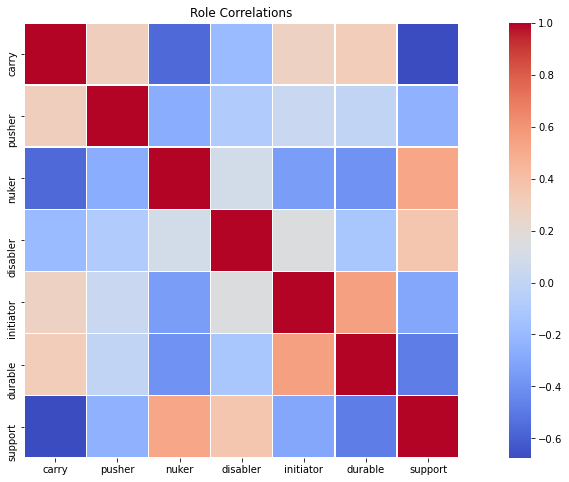

In [46]:
role_ix = data.columns[16:23]
role_corr = data[role_ix].corr()
plt.figure(figsize=(18,8))
sns.heatmap(role_corr, vmax=1, square=True, linewidth=.5, cmap="coolwarm")
plt.title('Role Correlations')

<ul>
    <li>There's a strong positive correlation between being an initiator and durable. This makes total sense, since almost every hero that's considered an initiator needs to be able to survive at least the initial response from enemy heros (if you know DotA, think Axe's Call, Tidehunter's Ravage, etc).</li>
    <li>Being a carry has a number of moderate negative correlations with other roles: nuker, disabler, and support. This makes sense since carry heroes are primarily focused on dealing as much right-click (regular attack) damage as possible.</li>
    <li>There's a moderate positive correlation with being a support and a nuker. Most heroes that support tend to have high magic damage spells (Lion's Finger of Death, Pugna's Netherblash, etc)</li>
</ul>

Let's now take a look at the percentage of games I've played in each role across all games, and and compare that with the distribution of each role in the total hero pool:

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([<matplotlib.axis.YTick at 0x7fdb180b6a60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

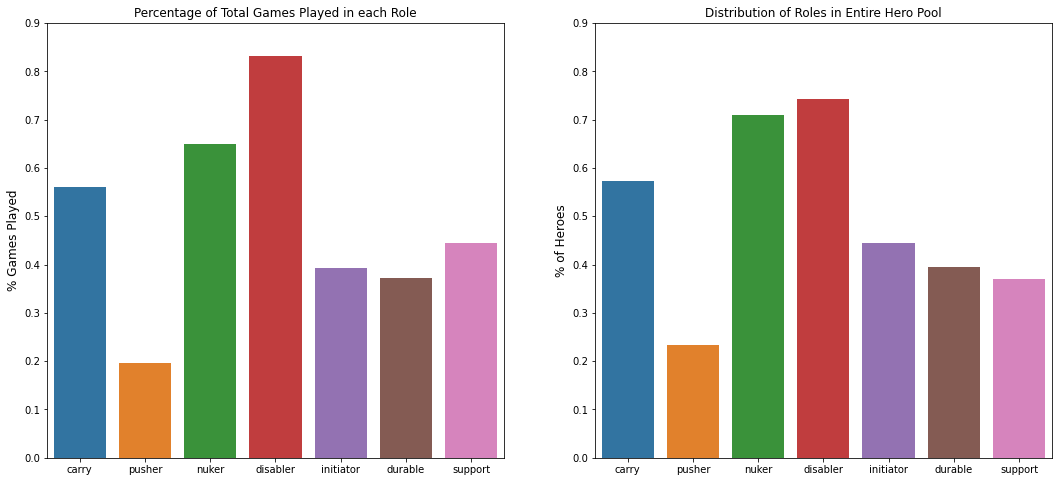

In [47]:
role_pct = []
for i in role_ix:
    role_pct.append((len(data[data[i] == 1]) / total_games))

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.barplot(role_ix, role_pct)
plt.title('Percentage of Total Games Played in each Role')
plt.ylabel('% Games Played', fontsize='large')
plt.yticks(np.arange(0.0, 1, 0.1))

role_dist_pct = hero_data[role_ix].sum() / total_hero_pool
plt.subplot(1,2,2)
sns.barplot(role_ix, role_dist_pct)
plt.title('Distribution of Roles in Entire Hero Pool')
plt.ylabel('% of Heroes', fontsize='large')
plt.yticks(np.arange(0.0, 1, 0.1))

In [48]:
role_differences = np.array(role_pct) - np.array(role_dist_pct)
print('Deltas between roles played and role distribution:')
list(zip(role_ix, (role_differences)))

Deltas between roles played and role distribution:


[('carry', -0.01222028480092996),
 ('pusher', -0.03747457134553908),
 ('nuker', -0.05922696890438828),
 ('disabler', 0.09049694856146473),
 ('initiator', -0.05075559430398141),
 ('durable', -0.022188317349607634),
 ('support', 0.07407730310956118)]

<ul>
    <li>The distribution of roles I played generally resembles the overall hero pool's distribution; this suggests that I often played heroes that fit within the most frequent roles (nuker, disabler, carry).</li>
    <li>Surprisingly my Percentage of Total Games Played in each Role correlates with the Distribution of Roles in Entire Hero Pool with slight variances.</li>
    <li>I played disabling heroes in almost 80% of all my games; with it having the highest delta. The combination of these roles most-played indicate a clear preference leaning towards powerful teamfighting heroes and less towards supportive initiators.</li>

Next, let's look at W/L, KDR, and KDA for each role:

In [49]:
role_wl = []
role_kdr = []
role_kda = []
for i in role_ix:
    role_group = data.groupby(i).mean()
    role_wl.append(role_group['result'][1])
    role_kdr.append(role_group['kdr'][1])
    role_kda.append(role_group['kda'][1])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'W/L')

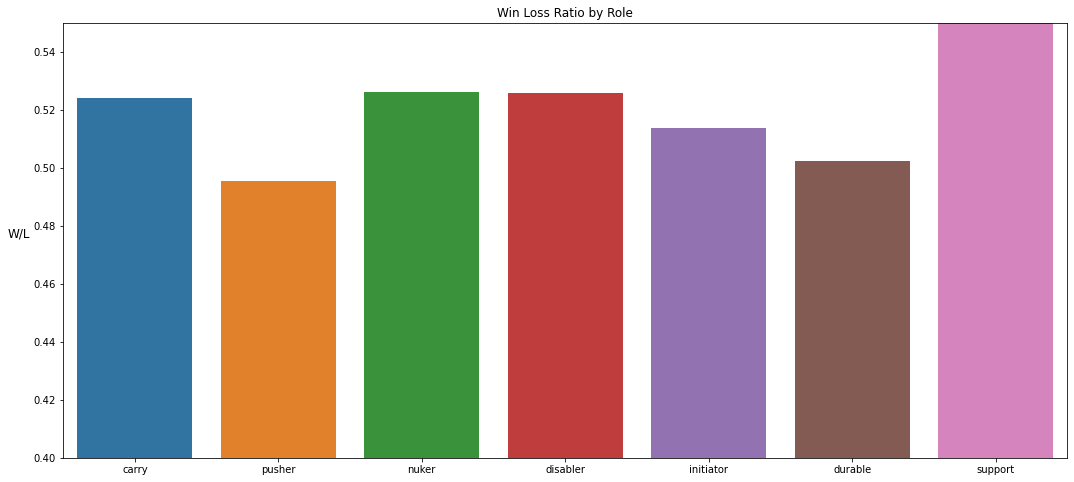

In [50]:
plt.figure(figsize=(18,8))
sns.barplot(role_ix, role_wl)
plt.ylim((0.4, 0.55))
plt.title('Win Loss Ratio by Role')
plt.ylabel('W/L', rotation='horizontal', horizontalalignment='right', fontsize='large')

In [51]:
list((zip(role_ix, role_wl)))

[('carry', 0.5241157556270096),
 ('pusher', 0.4954128440366973),
 ('nuker', 0.5263157894736842),
 ('disabler', 0.525974025974026),
 ('initiator', 0.5137614678899083),
 ('durable', 0.5024154589371981),
 ('support', 0.5506072874493927)]

It seems that Support in particular gives me an increased chance of winning, with carry, disabler, nuker, and durable all sitting at my average W/L ratio of ~0.52.

Pusher has about a -3% decrease from the average, suggesting that I'm slightly more likely to lose playing this role.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'KDA by Role')

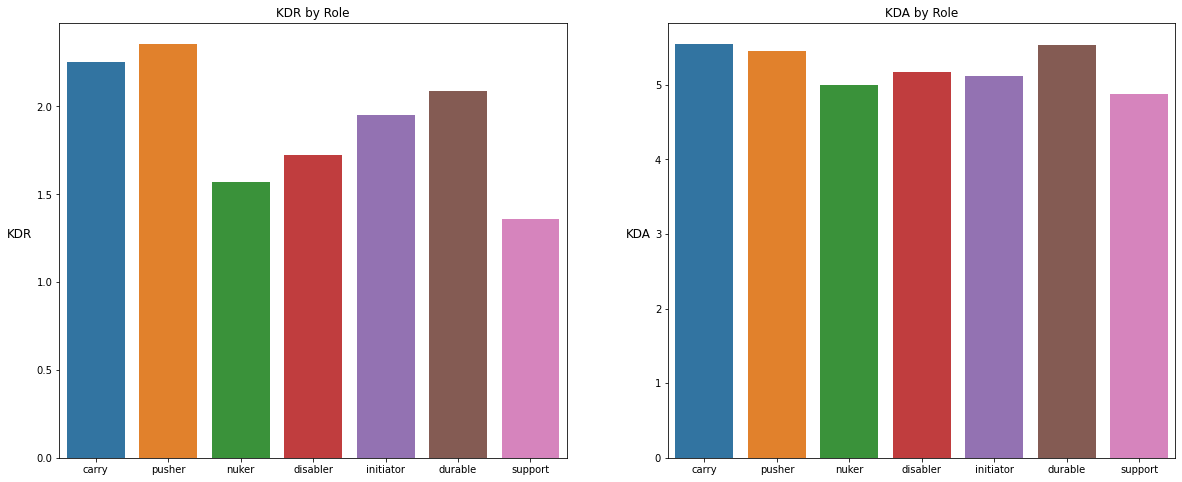

In [52]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(role_ix, role_kdr)
plt.ylabel('KDR', rotation='horizontal', horizontalalignment='right', fontsize='large')
plt.title('KDR by Role')

plt.subplot(1,2,2)
sns.barplot(role_ix, role_kda)
plt.ylabel('KDA', rotation='horizontal', horizontalalignment='right', fontsize='large')
plt.title('KDA by Role')

<ul>
    <li>Looking at KDR, pusher has a slight lead between itself and the other roles. Which is surprising considering I am slightly inclined to lose the game with a pusher role.</li>
    <li>KDA closes the distance between pusher and the other roles, as the inclusion of assists account for many of the key functions that teamfighting disablers, initiators, and supports play.</li>
    <li>Looking at the W/L, KDR, and KDA ratios together, it seems the best combination of roles to maximize my chances of winning is picking support heroes with the ability to disable in teamfights.</li>
</ul>

<h1>Time</h1>
DotA sucks away time like a black hole does to light - once you pass the event horizon, there is no escape from the void. The general relativity of each match causes time to slow to a crawl, especially when its a bad one. Yet time on the outside flows naturally... Minutes turn into hours, hours turn into days, and next thing you know you're 555 games deep and you carry with you the soul of a jaded old man.

All that being said, let's look at how my W/L ratio varies over particular lengths of time, starting with match duration:

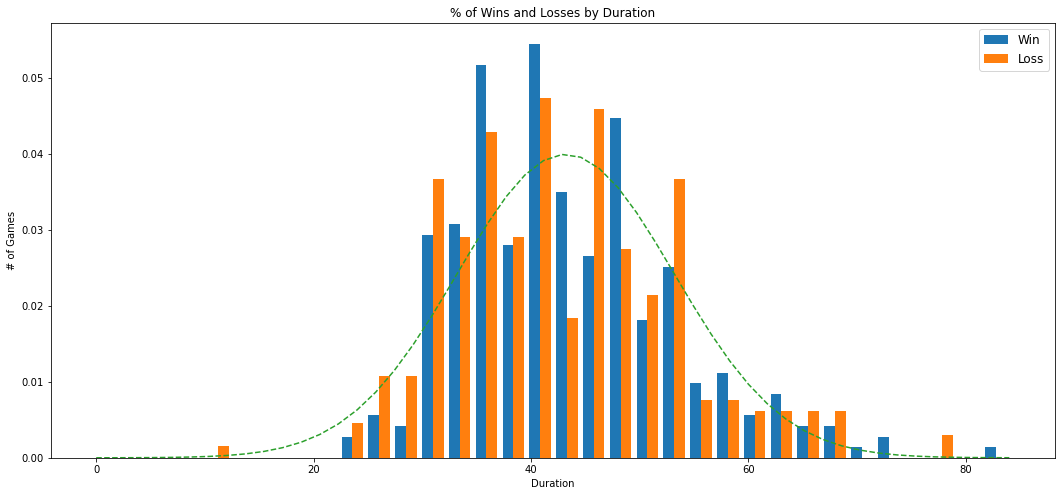

In [53]:
## Win/Loss by duration
#histogram
plt.figure(figsize=(18,8))
plt.hist([data['duration'].loc[data['result'] == 1],
        data['duration'].loc[data['result'] != 1]], stacked=False,
        bins=30, label=['Win', 'Loss'], density=True)
# gauss. curve
duration_space = np.linspace(0, data['duration'].max())
plt.plot(duration_space, stats.norm.pdf(duration_space, data['duration'].mean(),
                                        data['duration'].std()), '--')
plt.title('% of Wins and Losses by Duration')
plt.xlabel('Duration')
plt.ylabel('# of Games')
plt.legend(fontsize='large')

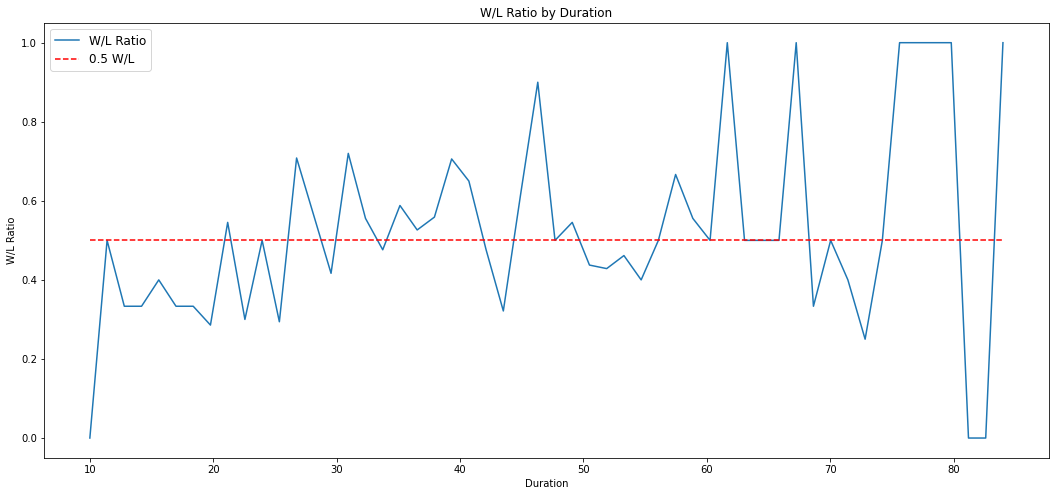

In [54]:
plt.figure(figsize=(18,8))
duration_wl = data.groupby('duration')['result'].mean()
duration_linspace = np.linspace(data['duration'].min(), data['duration'].max(), num=len(duration_wl))
plt.plot(duration_linspace, duration_wl, label='W/L Ratio')
plt.plot(duration_linspace, [0.5 for i in duration_linspace], 'r--', label='0.5 W/L')

plt.title('W/L Ratio by Duration')
plt.xlabel('Duration')
plt.ylabel('W/L Ratio')
plt.legend(fontsize='large')

Game duration fits a beautiful normal distribution around the average length of 42 minutes.

Looking at W/L ratio, you can see that it really fluctuates around the extremeties of duration (less than 20 mins and more than 70) because only a small number of games are ever that short or long. It seems that I'm more likely to lose shorter games between 20 and 30 minutes long, whereas my best window for success seems to between 35 to 50 minutes. Intuitively this makes total sense to me; in most games where I played as a carry, it took about 30 minutes to "come online", i.e. get powerful enough to start taking over the game. If the other team was able to push fast enough and force a win before or just at that point in time, the carry often wasn't powerful enough to really help the team stop their advance. But between 40 minutes to an hour, the carry has enough items and momentum to take over the game and go for the win.

Games over an hour long can be tricky, because past that point in time the outcome entirely comes down to team coordination and winning pivotal fights. By this late in the game most carries are max level and have their entire item builds, meaning how the team plays around them is essential to win.

I like the W/L ratio plot, because it really reflects how priorities and strategy change in DotA during different phases of the game. Now, let's take a look at my favourite (and most damning) visualization in this whole analysis: games played and W/L ratio distributed over 24 hours.

In [55]:
hourly_wl = data.groupby('hour')['result'].mean()/10 # divided by 10 so its scales visually with my histogram

In [56]:
hourly_wl.describe()

count    17.000000
mean      0.054014
std       0.020800
min       0.000000
25%       0.047619
50%       0.053333
75%       0.061905
max       0.100000
Name: result, dtype: float64

Text(0.5, 1.0, 'Games Played over 24 Hours')

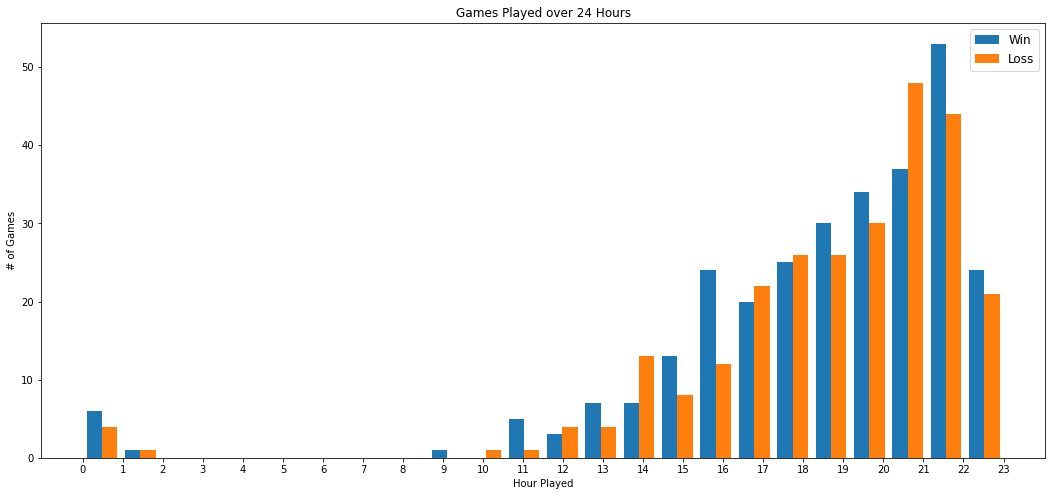

In [57]:
### Hourly games and W/L

plt.figure(figsize=(18,8))
plt.hist([data['hour'].loc[data['result'] == 1],
        data['hour'].loc[data['result'] != 1]], stacked=False,
        bins=24, label=['Win', 'Loss'], density=False)
plt.xlabel('Hour Played')
plt.xticks(range(24))
plt.ylabel('# of Games')
plt.legend(fontsize='large')
plt.title('Games Played over 24 Hours')

First of all, I'm not a complete degenerate so I do not have any games played between the hours of 2-8AM. It appears that the majority of my games are between 5-11PM. 

Because I do play on USWest and USEast servers I wonder if any of these particular valleys or peaks correlate with any of my teammates timezone compared to mine. For example: I fire up a game at 9PM PST and I'm matched with a player in Brazil 3-4 hours ahead of me. Does his tiredness come across in the game?

In [58]:
months_years = data.groupby(['year', 'month'])
months_wl = months_years['result'].mean()

In [59]:
timeline_wl = []

for year in range(2022, 2023):
    for month in range(1, 13):
        timeline_wl.append(months_wl.unstack()[month][year])
        
timeline_linspace = range(len(timeline_wl))

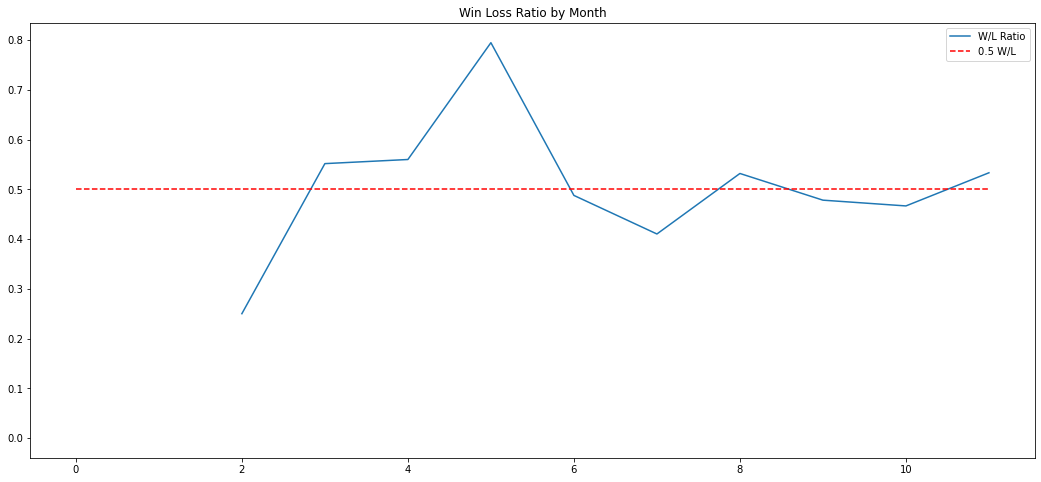

In [60]:
### Monthly W/L

plt.figure(figsize=(18,8))
plt.plot(timeline_linspace, timeline_wl, label='W/L Ratio')
plt.plot(timeline_linspace, [0.5 for i in timeline_linspace], 'r--', label="0.5 W/L")
plt.title('Win Loss Ratio by Month')
plt.legend()

Wow! If only every month could be like June of '22 for my games.

In [61]:
months_wl.unstack()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
2022,0.000000,NaN,0.250000,0.551724,0.56,0.794872,0.487805,0.410256,0.531915,0.478261,0.466667,0.533333
2023,0.482759,0.594595,0.510638,0.515152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's explore this this hot month further.

In [62]:
hot_month = data[data.year == 2022][data.month == 6]
hot_month['hero'].value_counts()

<ipython-input-62-d7590067d8df>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hot_month = data[data.year == 2022][data.month == 6]


Beastmaster         8
Chaos Knight        6
Snapfire            5
Slardar             4
Kunkka              3
Juggernaut          2
Monkey King         2
Dragon Knight       1
Phantom Assassin    1
Winter Wyvern       1
Grimstroke          1
Timbersaw           1
Viper               1
Drow Ranger         1
Disruptor           1
Lion                1
Name: hero, dtype: int64

And now exploration of the cold month.

In [63]:
cold_month = data[data.year == 2022][data.month == 8]
cold_month['hero'].value_counts()

<ipython-input-63-d68e73c77ac5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cold_month = data[data.year == 2022][data.month == 8]


Zeus                5
Snapfire            5
Puck                4
Warlock             3
Mars                2
Slardar             2
Dazzle              2
Viper               2
Legion Commander    2
Phantom Lancer      1
Razor               1
Timbersaw           1
Enchantress         1
Dawnbreaker         1
Beastmaster         1
Tidehunter          1
Omniknight          1
Juggernaut          1
Primal Beast        1
Chaos Knight        1
Death Prophet       1
Name: hero, dtype: int64

Dang! It looks like I was trying a lot of new heros out during this time. Hopefully that can explain the poor W/L Ratio.

In [64]:
## First, a nifty function to annotate barplots
def annotate(horizontal=False):
    ax = plt.gca()    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height() + 5, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


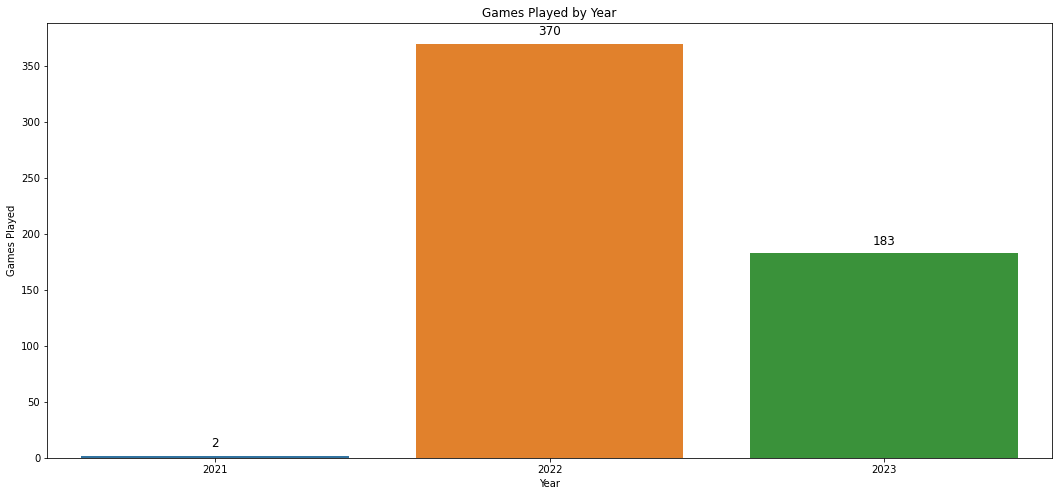

In [65]:
### Games played over the years

games_over_the_years = data['year'].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(games_over_the_years.index, games_over_the_years)
plt.title('Games Played by Year')
plt.ylabel('Games Played')
plt.xlabel('Year')
annotate()

Although I have played DotA for more years than these last 3. Opendota does not have the data for my games since I took such a long break. (Not that they'd be favorable)

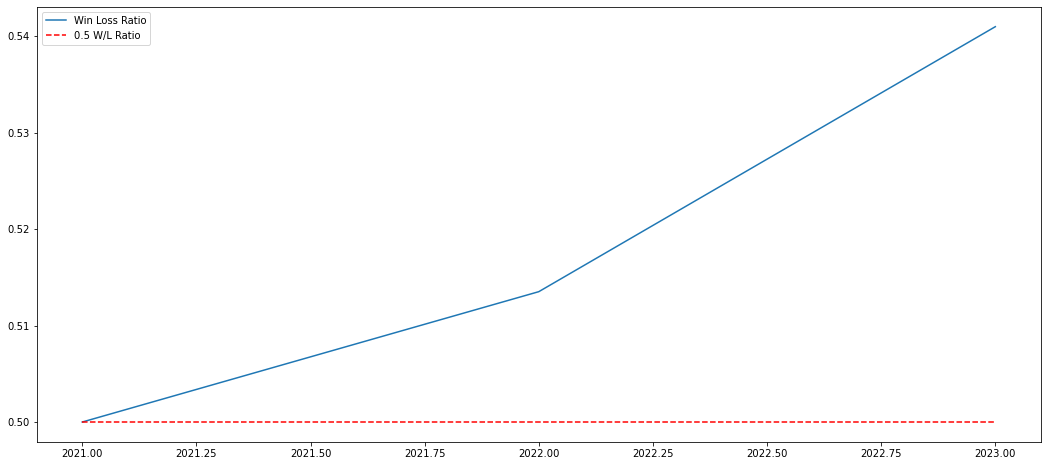

In [66]:
years = data.groupby('year')
years_wl = years['result'].mean()

plt.figure(figsize=(18,8))
plt.plot(years_wl.index, years_wl, label='Win Loss Ratio')
plt.plot(years_wl.index, [0.5 for i in years_wl.index], 'r--', label='0.5 W/L Ratio')
plt.legend()

Well that is a nice plot to see. I wonder at which point will it plateau or dare I say drop off.

<h1>Total Time in Game</h1>
Before I finish this analysis, there is one more depressing statistic I must come to bear. Just how much of my last two years did I spend honing untransferrable skills and arguing with other keyboard warriors in Dota 2? Let's break down the numbers:

In [67]:
total_minutes = data['duration'].sum()
total_minutes

23969.0

In [68]:
total_hours = total_minutes / 60
total_hours

399.48333333333335

In [69]:
total_days = total_hours / 24
total_days

16.64513888888889